In [83]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.gedi_viz import geo_plot
from src.visualization.dists import plot_pdf
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from src.data import k_nn

sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)
importlib.reload(k_nn)

2023-05-21 22:23:58,653 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [4]:
gedi_burned_trees, gedi_unburned_trees = gedi_pipeline.process_gedi_shots_for_regrowth_analysis('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv', True)

2023-05-21 18:51:53,988 DEBUG: Total number of GEDI shots available for the region:         9884257 [in process_gedi_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:101]
2023-05-21 18:52:26,125 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:36]
2023-05-21 18:52:26,495 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:41]
2023-05-21 18:52:27,952 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:47]
2023-05-21 18:52:28,433 DEBUG: Number of shots that happened after fires:                    1248004 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:64]
2023-05-21 18:52:28,695 DEBUG: Number of shots that burned exactly once:      

### Find nearest neighbours

In [7]:
nn_indeces, nn_distances, nn_avg_agbd = k_nn.nearest_neighbors(gedi_burned_trees, gedi_unburned_trees, 'agbd', 200)

In [8]:
gedi_burned_trees['rel_agbd'] = gedi_burned_trees.agbd / nn_avg_agbd
gedi_burned_trees['nn_avg_agbd'] = nn_avg_agbd
gedi_burned_trees['nn_index'] = range(0, nn_distances.shape[0])

In [ ]:
gedi_burned_trees.to_csv('/maps/fire-regen/data/burned_trees_rel_agbd_200_nn_median.csv')

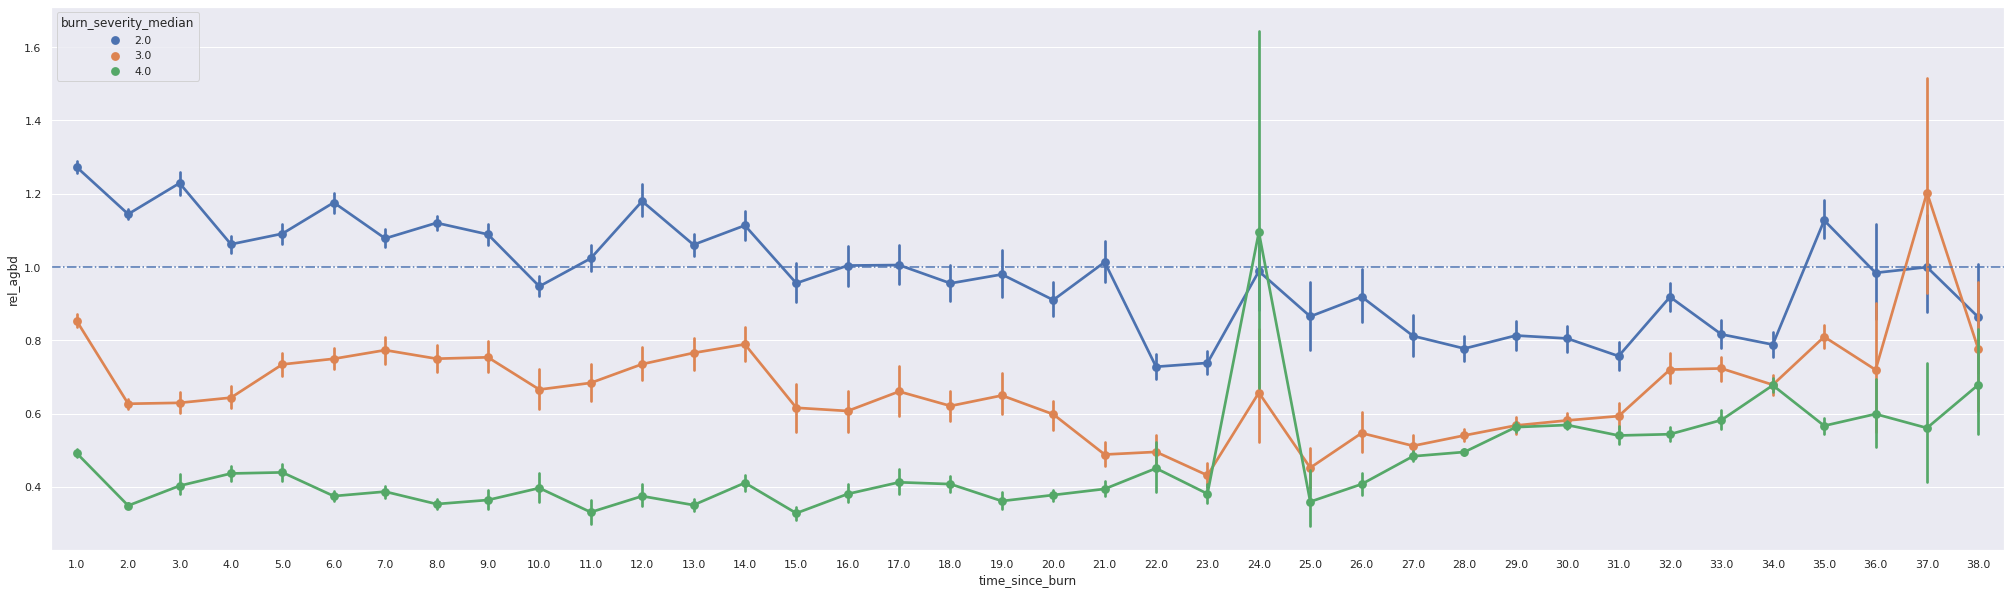

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

In [10]:
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==2][['rel_agbd', 'agbd', 'time_since_burn']].corr())
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==3][['rel_agbd', 'agbd', 'time_since_burn']].corr())
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4][['rel_agbd', 'agbd', 'time_since_burn']].corr())

                 rel_agbd      agbd  time_since_burn
rel_agbd         1.000000  0.759753        -0.121781
agbd             0.759753  1.000000        -0.192622
time_since_burn -0.121781 -0.192622         1.000000
                 rel_agbd      agbd  time_since_burn
rel_agbd         1.000000  0.833573        -0.058513
agbd             0.833573  1.000000        -0.128406
time_since_burn -0.058513 -0.128406         1.000000
                 rel_agbd      agbd  time_since_burn
rel_agbd         1.000000  0.825751         0.132587
agbd             0.825751  1.000000         0.052625
time_since_burn  0.132587  0.052625         1.000000


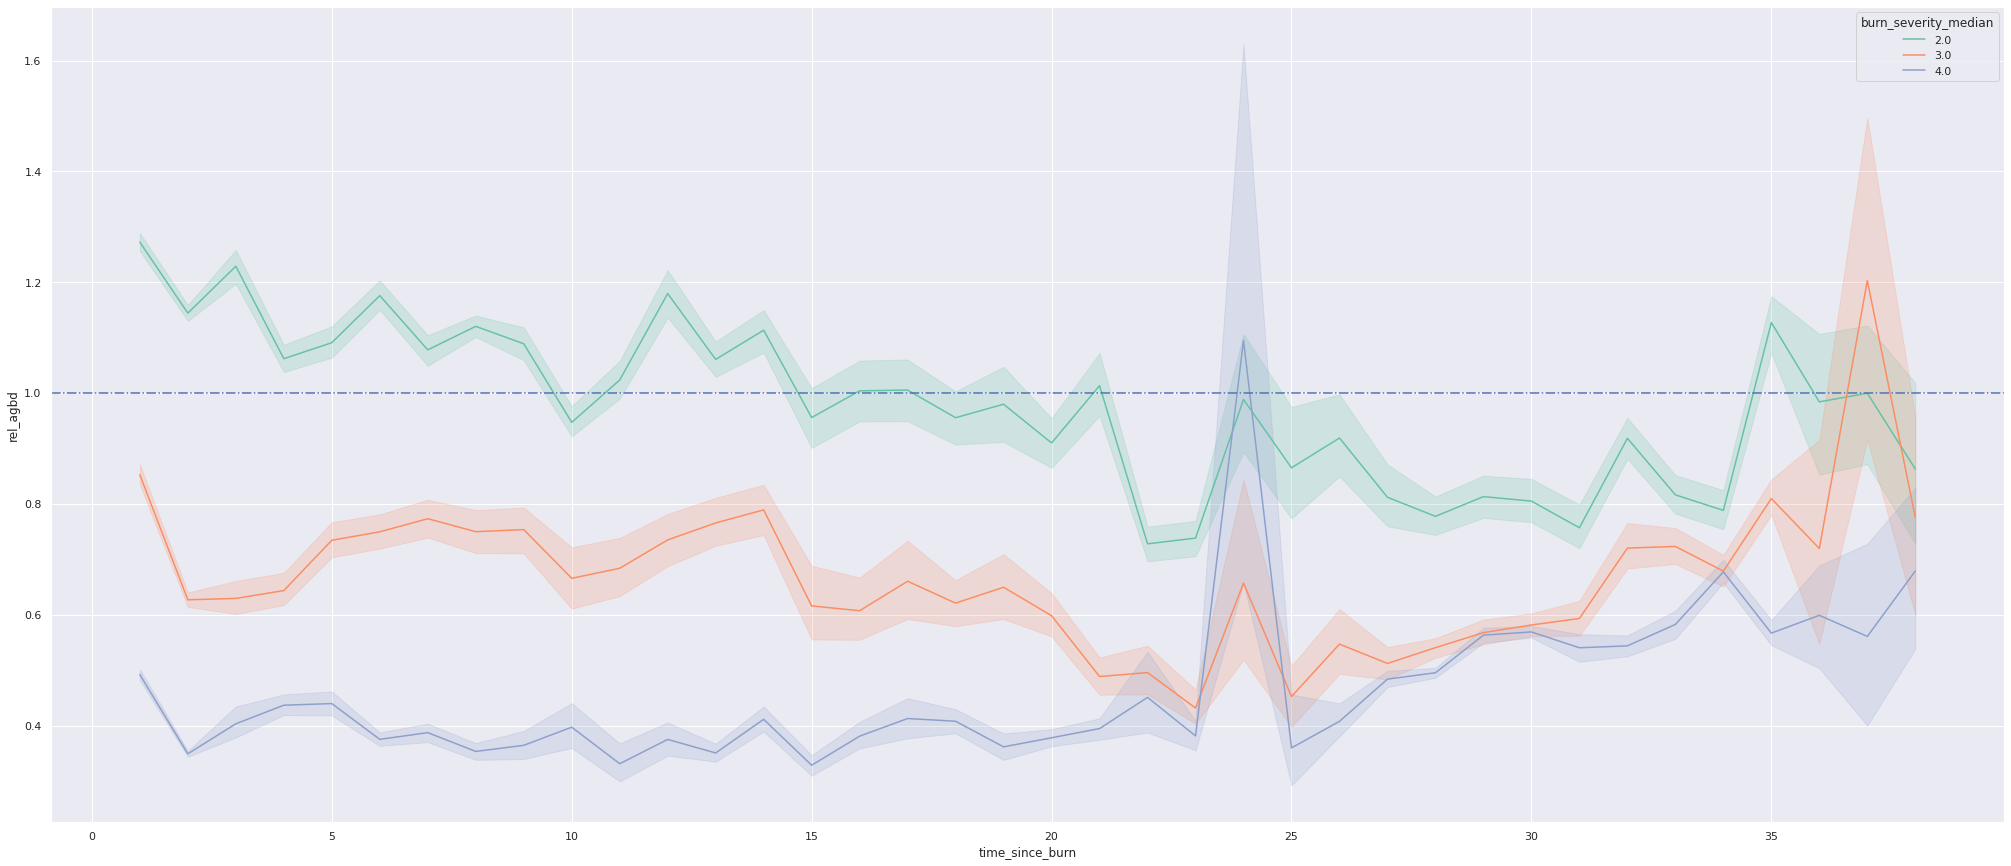

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.lineplot(gedi_burned_trees, x='time_since_burn', y='rel_agbd', hue='burn_severity_median', palette="Set2")
ax.axhline(y=1, linestyle="-.")

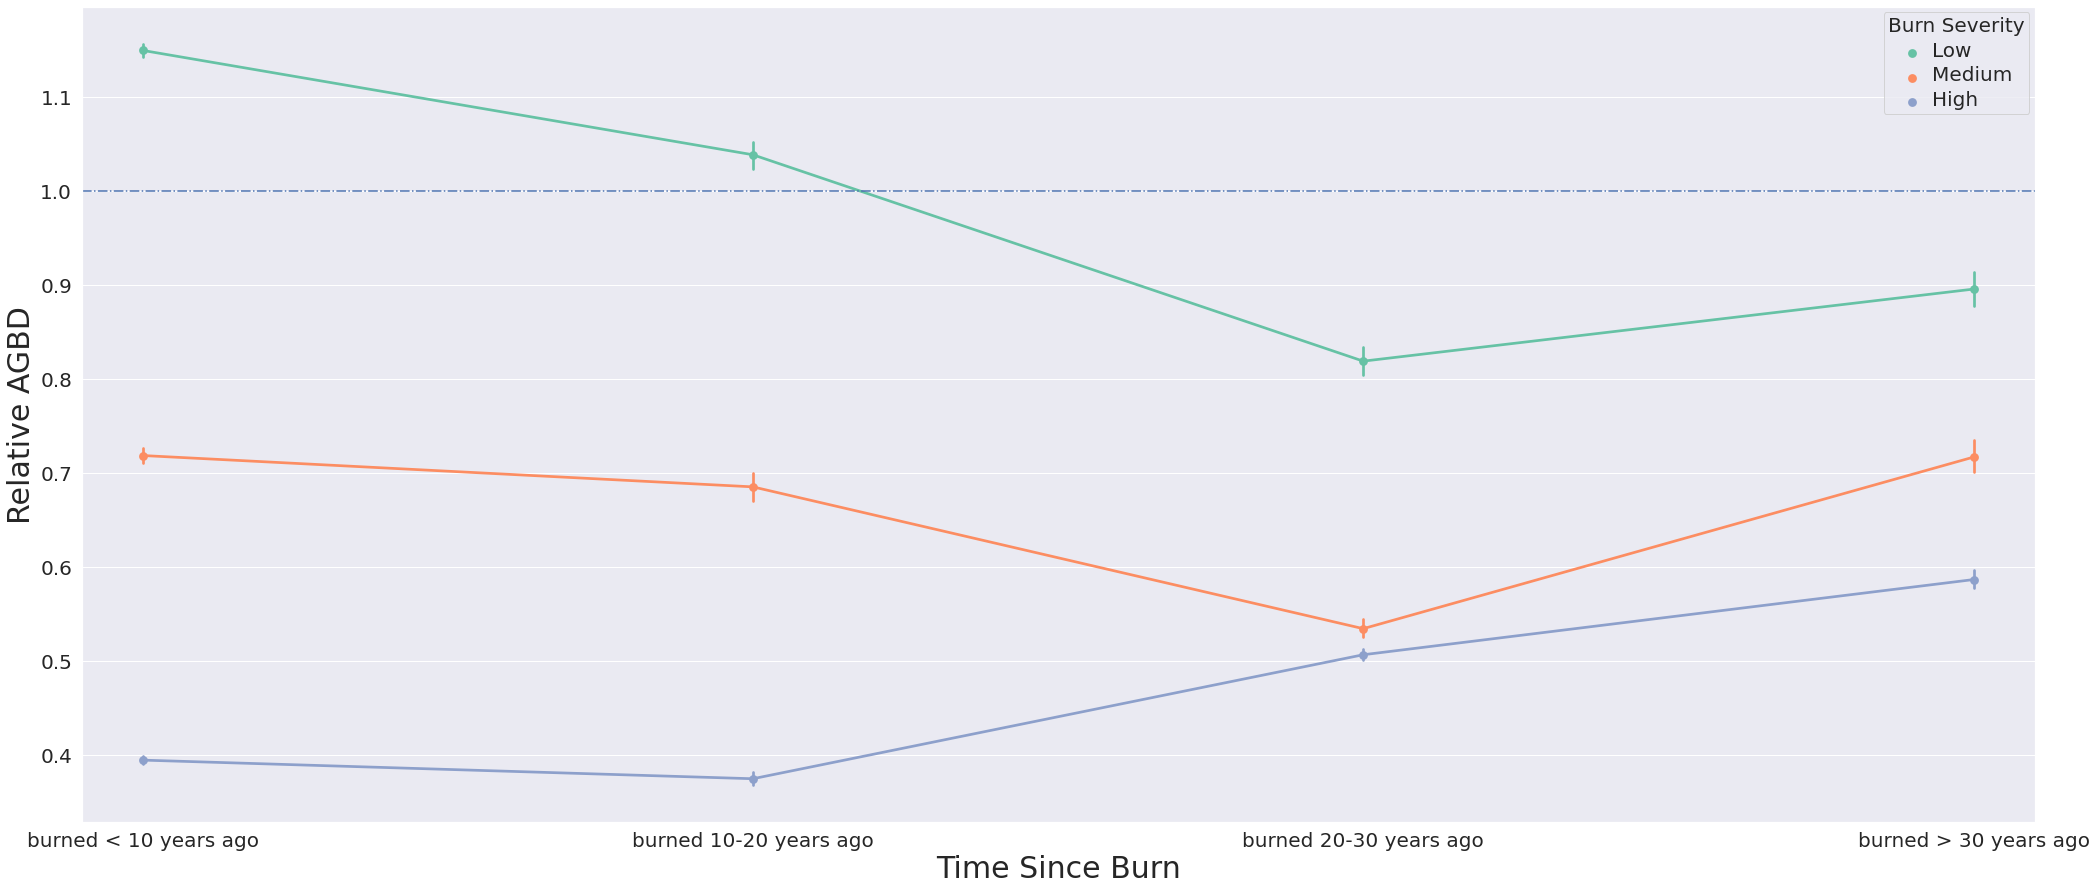

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_burned_trees, x='time_since_burn_cat', y='rel_agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('Relative AGBD', fontsize=30)
ax.axhline(y=1, ls="-.")

104239


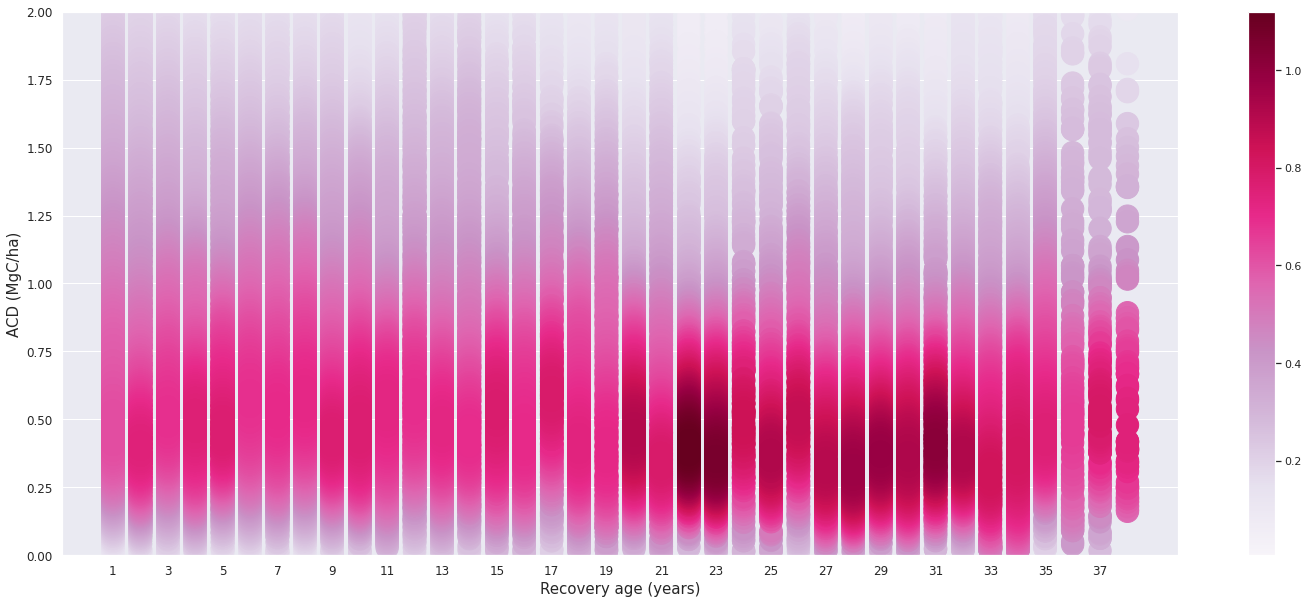

In [28]:
plot_pdf(gedi_burned_trees[(gedi_burned_trees.burn_severity_median == 2) & (gedi_burned_trees.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

57017


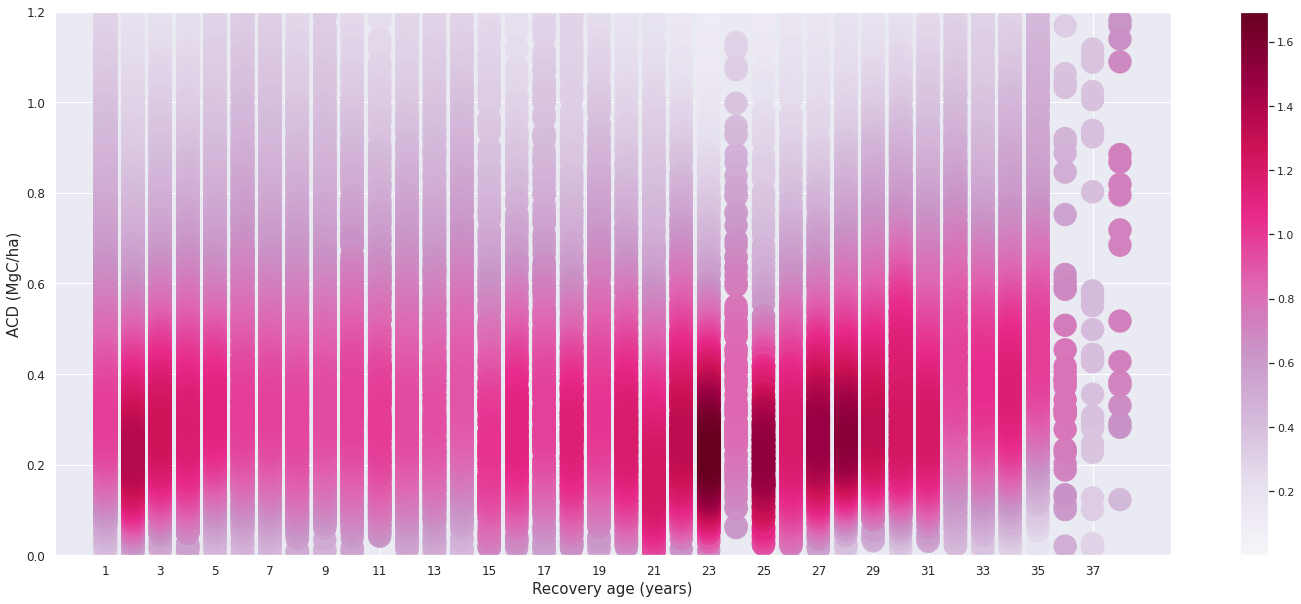

In [29]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1.2))

94900


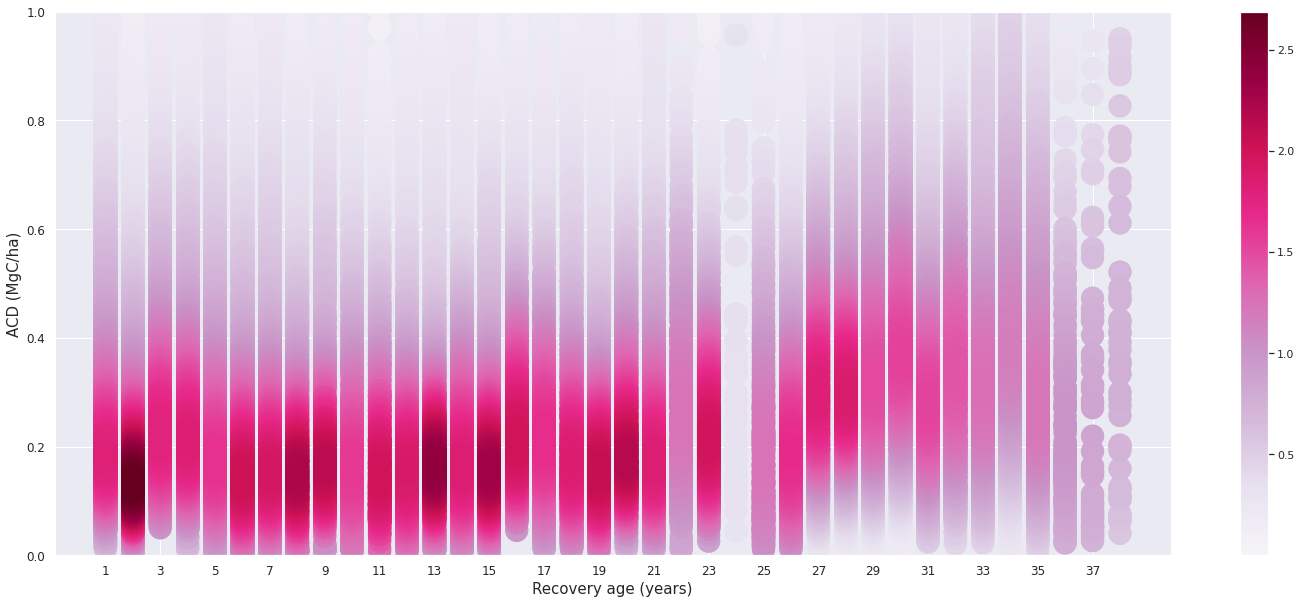

In [30]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4],
         'time_since_burn',
         'rel_agbd',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 1))

### Density Plots

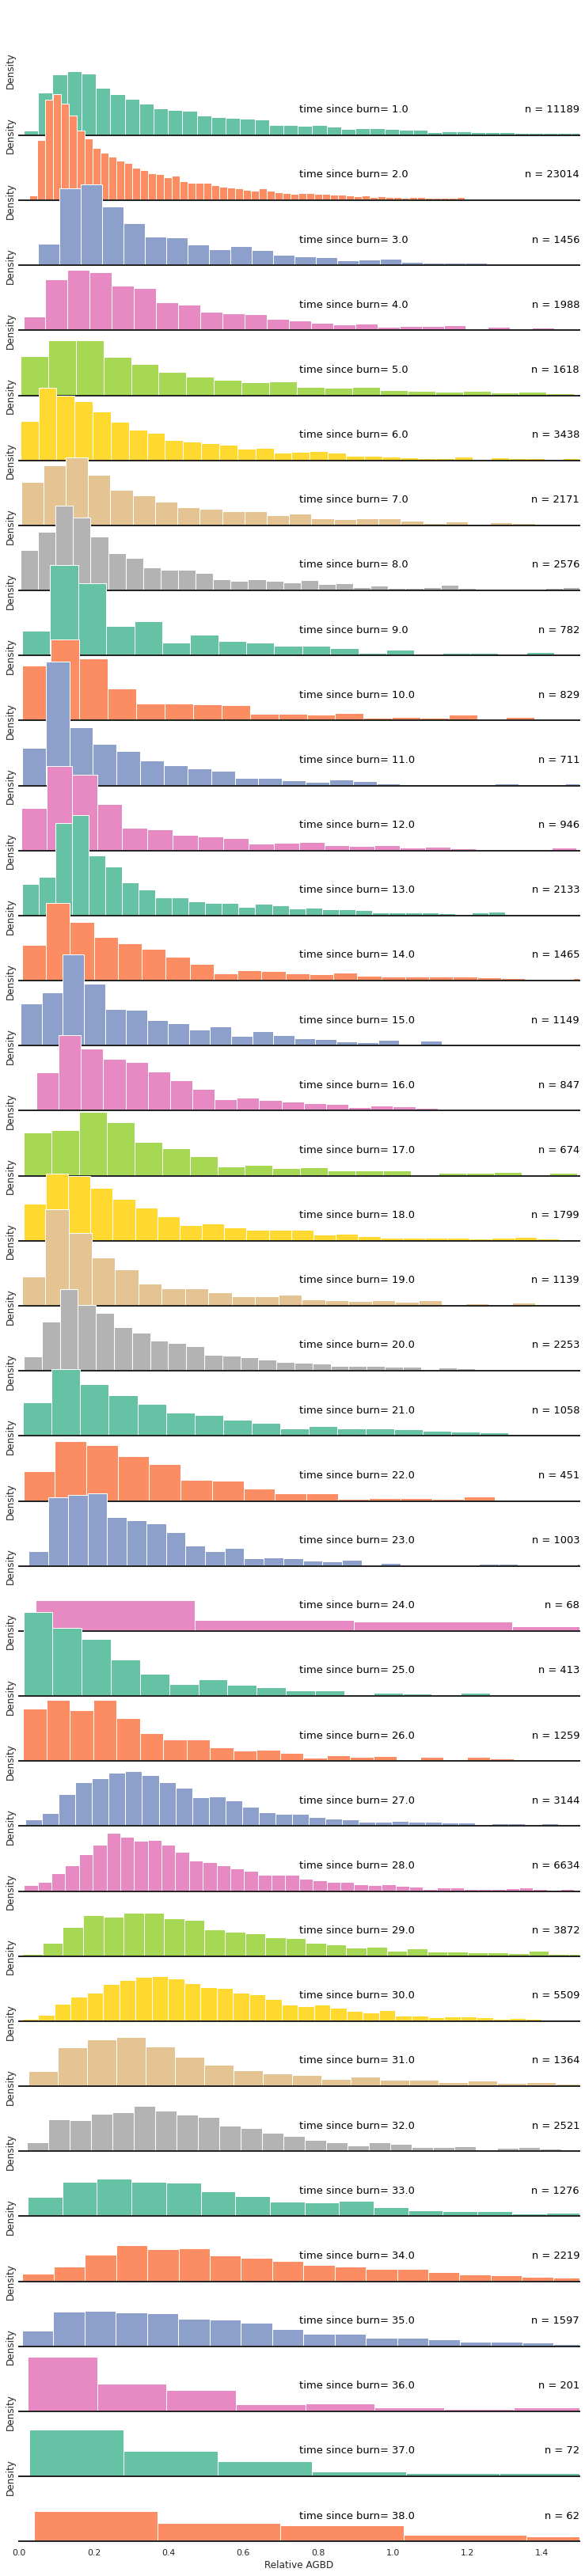

In [88]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4], palette=palette, row="time_since_burn", hue="time_since_burn", aspect=9, height=1.2, xlim=[0,1.5])
g.map_dataframe(sns.histplot, x="rel_agbd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'time since burn= {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Relative AGBD")
g.despine( left=True)

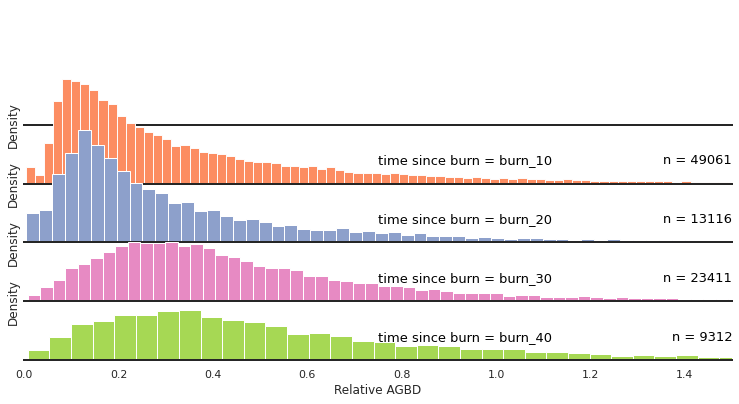

In [87]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4], palette=palette, row="time_since_burn_cat", hue="time_since_burn_cat", aspect=9, height=1.2, xlim=[0,1.5])
g.map_dataframe(sns.histplot, x="rel_agbd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'time since burn = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn_cat")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Relative AGBD")
g.despine( left=True)

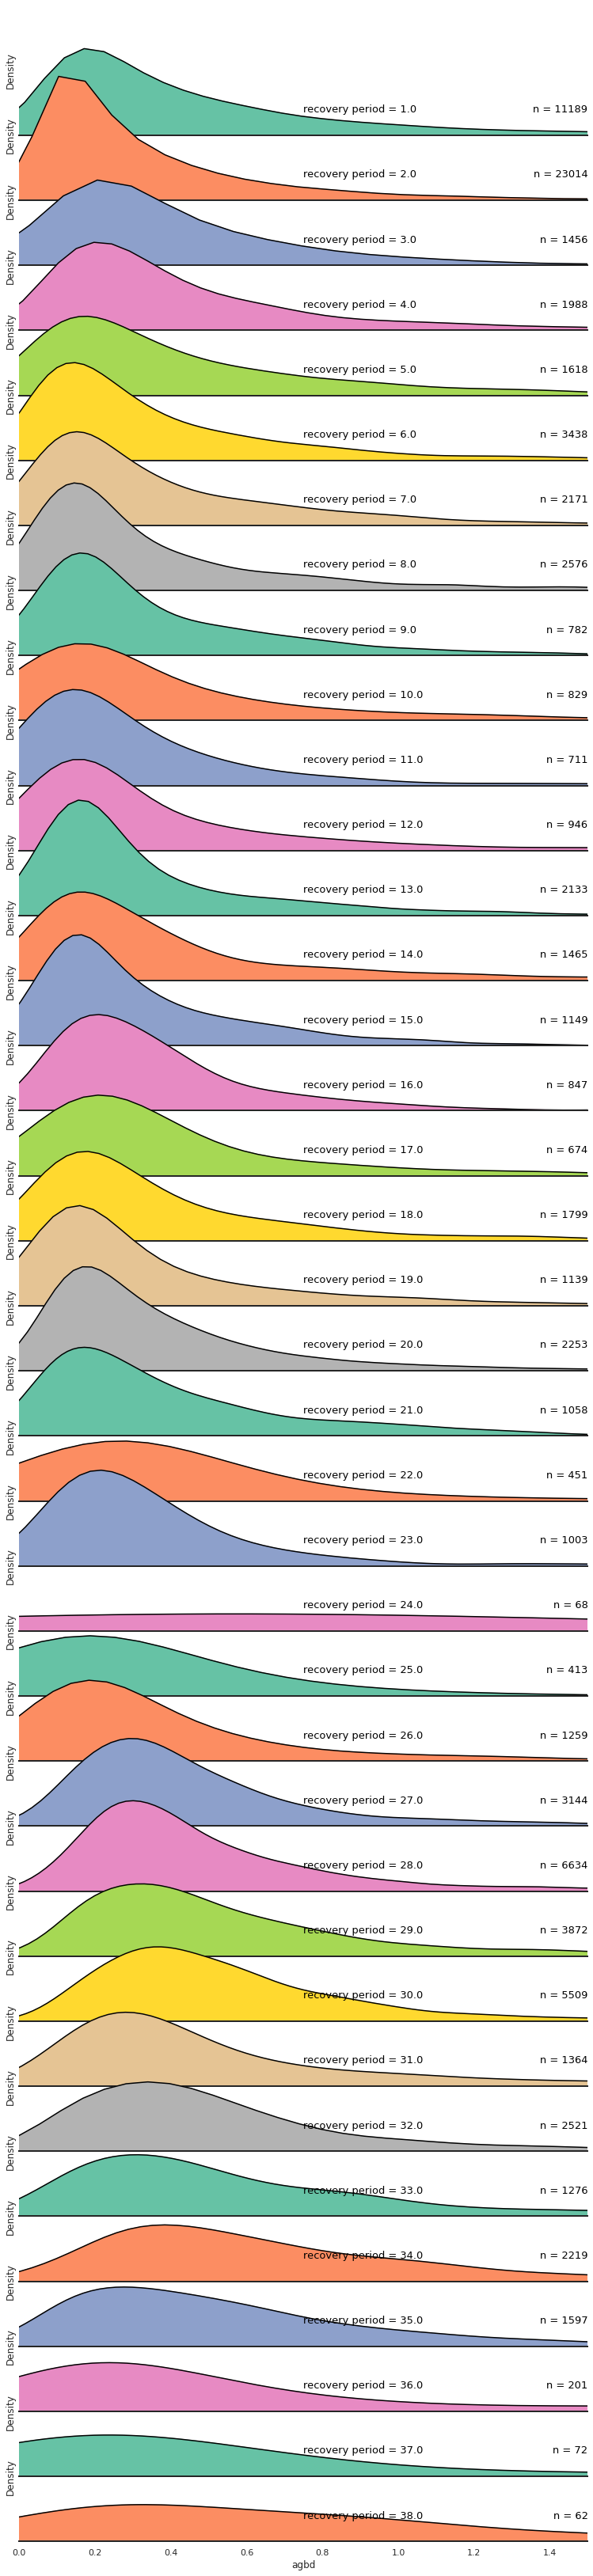

In [33]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4], palette=palette, row="time_since_burn", hue="time_since_burn", aspect=9, height=1.2, xlim=[0,1.5])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

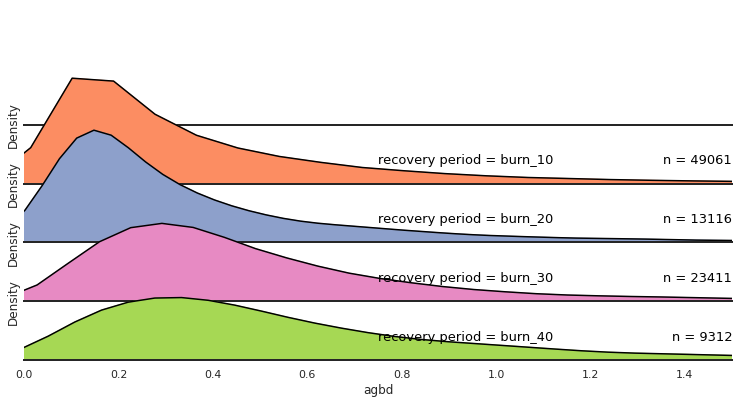

In [34]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4], palette=palette, row="time_since_burn_cat", hue="time_since_burn_cat", aspect=9, height=1.2, xlim=[0,1.5])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

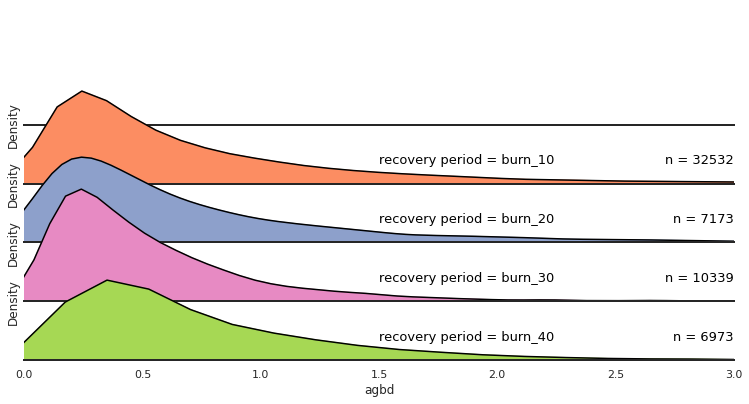

In [35]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==3], palette=palette, row="time_since_burn_cat", hue="time_since_burn_cat", aspect=9, height=1.2, xlim=[0, 3])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

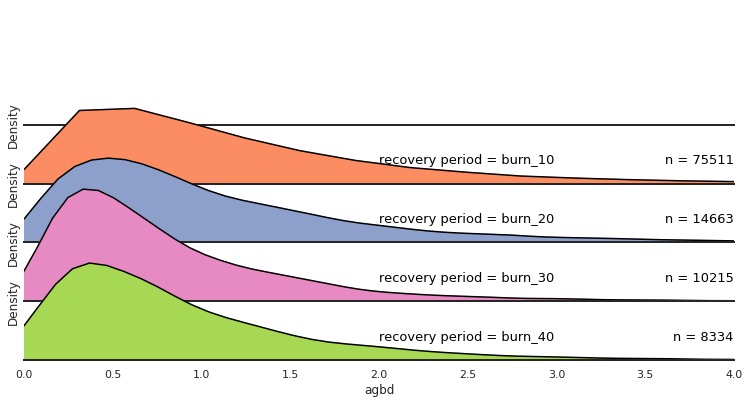

In [36]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_burned_trees[gedi_burned_trees.burn_severity_median==2], palette=palette, row="time_since_burn_cat", hue="time_since_burn_cat", aspect=9, height=1.2, xlim=[0, 4])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

### Polynomial regression

In [113]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)

gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]
gedi_burn_4 = gedi_burn_4[gedi_burn_4.time_since_burn > 2]
gedi_burn_4 = stats.remove_outliers(gedi_burn_4, 'agbd')
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn < 35)]
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 35)]
#model = sm.OLS(gedi_burn_4['rel_agbd'], polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])).fit()
#model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

#print(model.summary())
#polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])
x = np.reshape(gedi_burn_4['time_since_burn'].to_numpy(), (gedi_burn_4['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(gedi_burn_4['agbd'].to_numpy(), (gedi_burn_4['agbd'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1374.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:20:44   Log-Likelihood:            -3.0206e+05
No. Observations:               58889   AIC:                         6.041e+05
Df Residuals:                   58886   BIC:                         6.042e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.2388      0.685     77.744      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


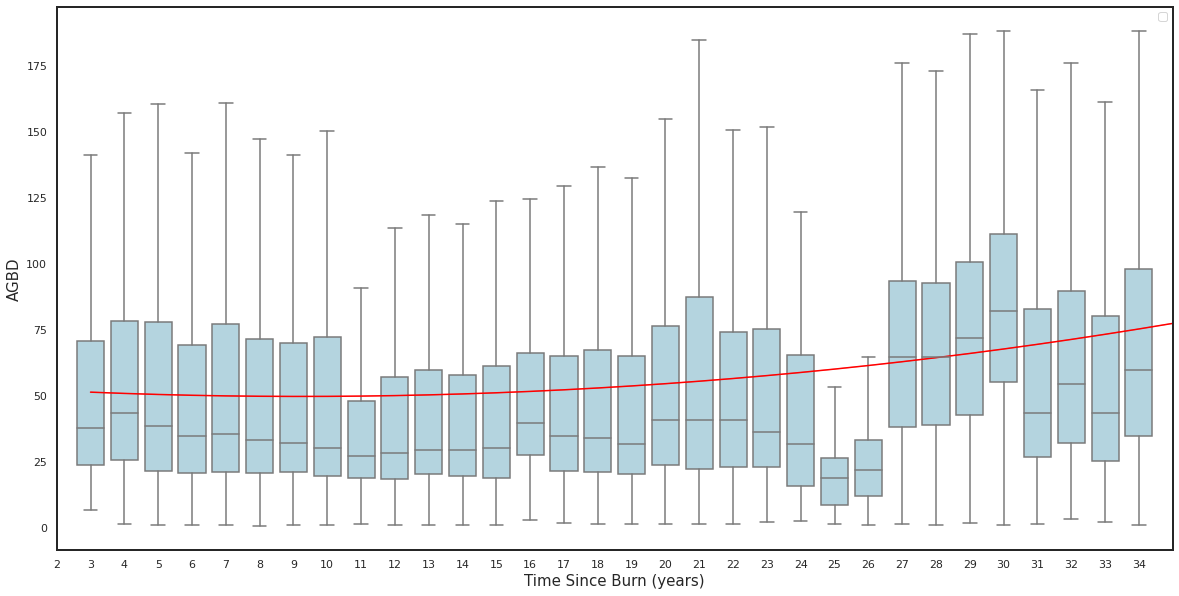

In [115]:
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="agbd", data=gedi_burn_4, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("AGBD", fontsize=15)
ax.set_xlabel("Time Since Burn (years)", fontsize=15)
ax.set_xlim([2,35])
xs = np.arange(2, 35)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))


sns.lineplot(x=gedi_burn_4.time_since_burn, y=ypred, color='red', ax=ax)

#ax.plot(xs, lin_agcd.intercept + lin_agcd.slope * xs, 'r', label='OLS')
#text_label = (
#    "OLS Regression:\n"
#    "R-value: {0:.2f}\n"
#    "slope: {1:.2f} MgC/ha/yr\n"
#    "intercept: {2:.2f} Mg/ha").format(
#        lin_agcd.rvalue, lin_agcd.slope, lin_agcd.intercept)
#ax.text(x=6, y=205, s=text_label, fontsize=14)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

In [106]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)

gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]
gedi_burn_4 = gedi_burn_4[gedi_burn_4.time_since_burn > 2]
gedi_burn_4 = stats.remove_outliers(gedi_burn_4, 'rel_agbd')
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn < 35)]
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 35)]
#model = sm.OLS(gedi_burn_4['rel_agbd'], polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])).fit()
#model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

#print(model.summary())
#polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])
x = np.reshape(gedi_burn_4['time_since_burn'].to_numpy(), (gedi_burn_4['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(gedi_burn_4['rel_agbd'].to_numpy(), (gedi_burn_4['rel_agbd'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1932.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:16:26   Log-Likelihood:                -3155.0
No. Observations:               57164   AIC:                             6316.
Df Residuals:                   57161   BIC:                             6343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3702      0.004     85.723      0.0

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd'>

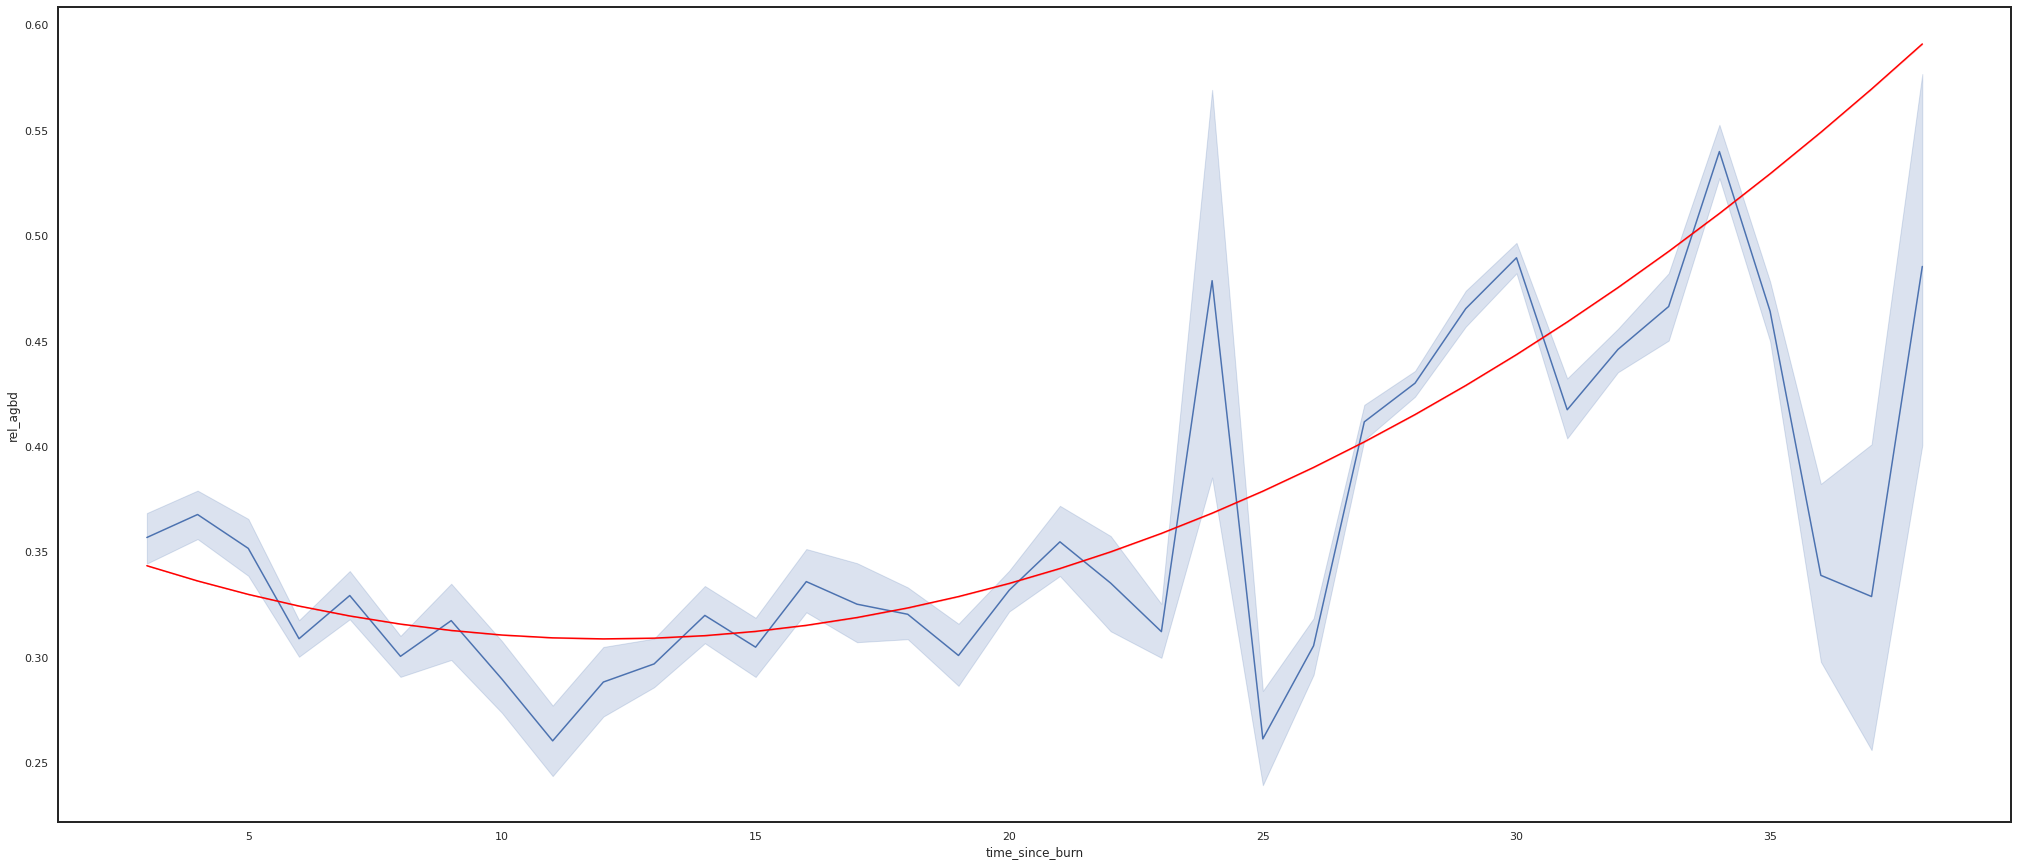

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.lineplot(gedi_burn_4, x='time_since_burn', y='rel_agbd', ax=ax)
sns.lineplot(x=gedi_burn_4.time_since_burn, y=ypred, color='red', ax=ax)
#sns.lineplot(x=gedi_burn_4.time_since_burn, y=upper, color='green', ax=ax)
#sns.lineplot(x=gedi_burn_4.time_since_burn, y=lower, color='green', ax=ax)
#plt.scatter(x, y)
#plt.pointplot(x, ypred, color='red')
#plt.ylim((0, 2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


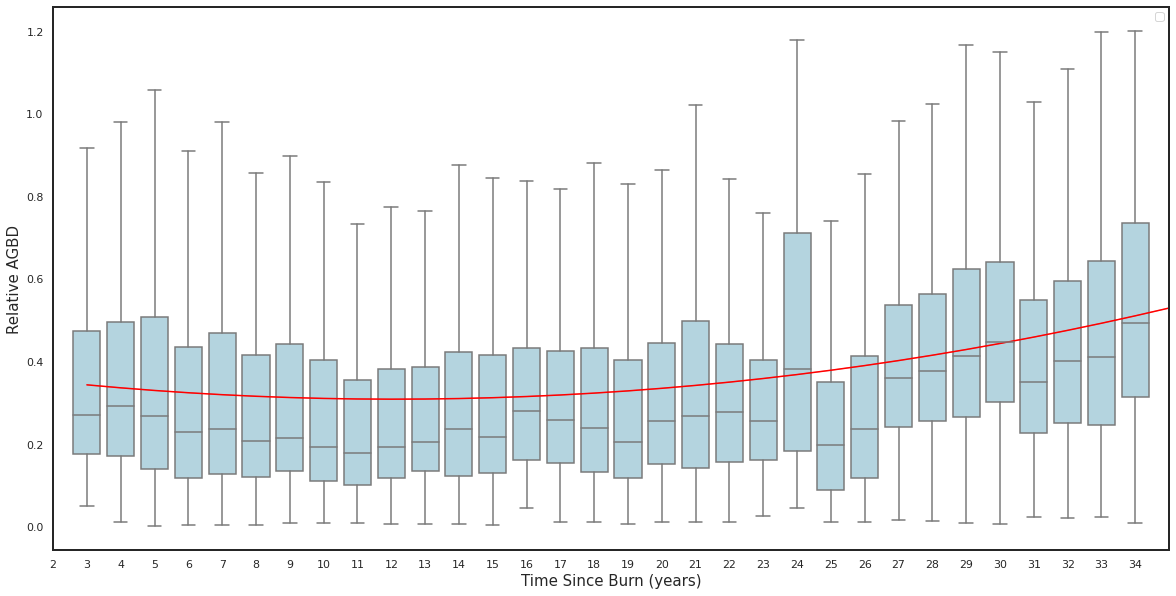

In [111]:
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_burn_4, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("Relative AGBD", fontsize=15)
ax.set_xlabel("Time Since Burn (years)", fontsize=15)
ax.set_xlim([2,35])
xs = np.arange(2, 35)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))


sns.lineplot(x=gedi_burn_4.time_since_burn, y=ypred, color='red', ax=ax)

#ax.plot(xs, lin_agcd.intercept + lin_agcd.slope * xs, 'r', label='OLS')
#text_label = (
#    "OLS Regression:\n"
#    "R-value: {0:.2f}\n"
#    "slope: {1:.2f} MgC/ha/yr\n"
#    "intercept: {2:.2f} Mg/ha").format(
#        lin_agcd.rvalue, lin_agcd.slope, lin_agcd.intercept)
#ax.text(x=6, y=205, s=text_label, fontsize=14)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

### Linear regression

In [74]:
gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]
gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 35)]
model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               rel_agbd   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1541.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        19:38:51   Log-Likelihood:                -35440.
No. Observations:               58765   AIC:                         7.088e+04
Df Residuals:                   58763   BIC:                         7.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3139      0.004     

### Quantile Regression

In [78]:
import statsmodels.formula.api as smf

In [79]:
mod = smf.quantreg("rel_agbd ~ time_since_burn", gedi_burn_4)

In [80]:
quantiles = np.arange(0.05, 0.96, 0.01)
def fit_model(q):
    res = mod.fit(q=q)
    return [
        q, 
        res.params["Intercept"],
        *res.conf_int().loc["Intercept"],
        res.params["time_since_burn"],
        *res.conf_int().loc["time_since_burn"],
        res.prsquared,
    ]


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "la", "ua", "b", "lb", "ub", "prs"])
print(models)

print(mod.fit(q=0.5).summary())
median = fit_model(0.5)
median = dict(
    q=median[0],
    a=median[1],
    la=median[2],
    ua=median[3],
    b=median[4],
    lb=median[5],
    ub=median[6],
    prs = median[7]
)

bestmod = models[models.prs == models.prs.max()].iloc[0]
print(bestmod)

       q         a        la        ua         b        lb        ub       prs
0   0.05  0.019087  0.015823  0.022350  0.003009  0.002866  0.003151  0.025519
1   0.06  0.028272  0.025254  0.031289  0.002971  0.002840  0.003103  0.027055
2   0.07  0.032467  0.029511  0.035422  0.003101  0.002972  0.003230  0.028387
3   0.08  0.034881  0.031954  0.037809  0.003287  0.003160  0.003415  0.029283
4   0.09  0.036984  0.034075  0.039893  0.003502  0.003375  0.003628  0.030123
..   ...       ...       ...       ...       ...       ...       ...       ...
86  0.91  0.672996  0.658653  0.687340  0.005076  0.004430  0.005722  0.011155
87  0.92  0.702851  0.688760  0.716942  0.004918  0.004283  0.005553  0.010456
88  0.93  0.732496  0.718391  0.746601  0.004727  0.004091  0.005363  0.009784
89  0.94  0.771808  0.757222  0.786394  0.004306  0.003648  0.004963  0.008939
90  0.95  0.806856  0.791300  0.822413  0.004251  0.003549  0.004953  0.008246

[91 rows x 8 columns]
                         Quan

(0.0, 2.0)

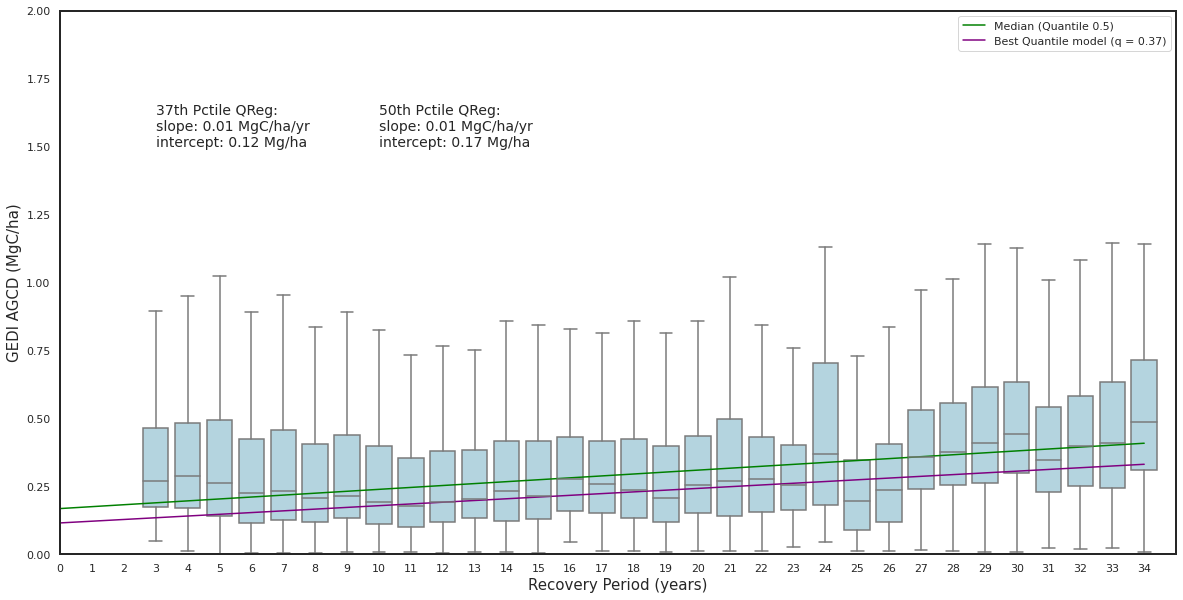

In [81]:
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_burn_4, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("GEDI AGCD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,35])
xs = np.arange(0, 35)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))


med_ys = get_ys(median['a'], median['b'])
ax.plot(xs, med_ys, color='green', label='Median (Quantile 0.5)')

ys_best = get_ys(bestmod['a'], bestmod['b'])
ax.plot(xs, ys_best, color='purple', label='Best Quantile model (q = {0:.2f})'.format(bestmod['q']))

#ax.plot(xs, lin_agcd.intercept + lin_agcd.slope * xs, 'r', label='OLS')
#text_label = (
#    "OLS Regression:\n"
#    "R-value: {0:.2f}\n"
#    "slope: {1:.2f} MgC/ha/yr\n"
#    "intercept: {2:.2f} Mg/ha").format(
#        lin_agcd.rvalue, lin_agcd.slope, lin_agcd.intercept)
#ax.text(x=6, y=205, s=text_label, fontsize=14)

text_label_2 = (
    "50th Pctile QReg:\n"
    "slope: {0:.2f} MgC/ha/yr\n"
    "intercept: {1:.2f} Mg/ha").format(
        median['b'], median['a'])
ax.text(x=10, y=1.5, s=text_label_2, fontsize=14)

text_label_3 = (
    "{0:.0f}th Pctile QReg:\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} Mg/ha").format(
        bestmod['q'] * 100, bestmod['b'], bestmod['a'])
ax.text(x=3, y=1.5, s=text_label_3, fontsize=14)
ax.legend(facecolor='white')
ax.set_ylim([0, 2])